In [18]:
# Cell 1: Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
import glob

# Set a random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)


In [19]:
# Load the dataset from .txt files in the specified directory
def load_data(directory_path):
    # Use glob to get all .txt files in the directory
    file_paths = glob.glob(os.path.join(directory_path, "*.txt"))
    
    data = []
    for file_path in file_paths:
        with open(file_path, 'r') as file:
            lines = file.readlines()
        
        # Read each block of 5 points from the file
        for i in range(0, len(lines), 6):  # Each block is 5 points + 1 line (empty line or header)
            # Check if the block has exactly 5 lines for points
            if len(lines[i+1:i+6]) == 5:
                points = np.array([list(map(float, line.split())) for line in lines[i+1:i+6]])
                data.append(points)
            else:
                # If there's an issue (like not enough points), you can decide to skip or fill with NaNs/zeros
                print(f"Skipping an incomplete block in file {file_path}")
                continue
    
    return np.array(data)

# Function to compute volume of tetrahedron using 5 points
def compute_volume(points):
    a = points[0]
    b = points[1]
    c = points[2]
    d = points[3]
    e = points[4]
    volume = np.abs(np.dot(e - a, np.cross(b - a, c - a)) / 6.0)
    return volume

# Directory path to the dataset
directory_path = './3d_point_cloud_dataset'  # Path to the folder containing your .txt files

# Load the data from the files in the directory
data = load_data(directory_path)

# Check if data has any entries and ensure it's in the correct shape
if data.size == 0:
    raise ValueError("No valid data found. Check the dataset files.")

# Compute volumes for all samples
volumes = np.array([compute_volume(points) for points in data])

# Normalize data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data.reshape(-1, 15)).reshape(-1, 5, 3)
volumes = volumes.reshape(-1, 1)

# Split into train and test sets
train_data, test_data, train_volumes, test_volumes = train_test_split(data_scaled, volumes, test_size=0.2, random_state=42)


Skipping an incomplete block in file ./3d_point_cloud_dataset/convex_hull_2201.txt
Skipping an incomplete block in file ./3d_point_cloud_dataset/convex_hull_3103.txt
Skipping an incomplete block in file ./3d_point_cloud_dataset/convex_hull_1491.txt
Skipping an incomplete block in file ./3d_point_cloud_dataset/convex_hull_2062.txt
Skipping an incomplete block in file ./3d_point_cloud_dataset/convex_hull_1665.txt
Skipping an incomplete block in file ./3d_point_cloud_dataset/convex_hull_4045.txt
Skipping an incomplete block in file ./3d_point_cloud_dataset/convex_hull_3125.txt
Skipping an incomplete block in file ./3d_point_cloud_dataset/convex_hull_3130.txt
Skipping an incomplete block in file ./3d_point_cloud_dataset/convex_hull_824.txt
Skipping an incomplete block in file ./3d_point_cloud_dataset/convex_hull_1701.txt
Skipping an incomplete block in file ./3d_point_cloud_dataset/convex_hull_4909.txt
Skipping an incomplete block in file ./3d_point_cloud_dataset/convex_hull_1221.txt
Skipp

In [20]:
# Cell 3: Define custom dataset class
class PointCloudDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return torch.tensor(self.data[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.float32)

# Create train and test datasets
train_dataset = PointCloudDataset(train_data, train_volumes)
test_dataset = PointCloudDataset(test_data, test_volumes)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [21]:
# Cell 4: Define the Transformer model
class TransformerRegression(nn.Module):
    def __init__(self, input_dim, embed_dim, num_heads, num_layers, ff_dim):
        super(TransformerRegression, self).__init__()
        self.embedding = nn.Linear(input_dim, embed_dim)
        self.transformer = nn.Transformer(
            d_model=embed_dim, 
            nhead=num_heads, 
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers,
            dim_feedforward=ff_dim,
            batch_first=True
        )
        self.regressor = nn.Linear(embed_dim, 1)

    def forward(self, x):
        embedded = self.embedding(x)
        transformed = self.transformer(embedded, embedded)
        output = self.regressor(transformed[:, 0])  # Use the first token for regression
        return output

# Hyperparameters
input_dim = 3
embed_dim = 64
num_heads = 4
num_layers = 2
ff_dim = 128

# Instantiate the model
model = TransformerRegression(input_dim, embed_dim, num_heads, num_layers, ff_dim).to('cuda' if torch.cuda.is_available() else 'cpu')


In [ ]:
# Cell 5: Define training utilities
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training function
def train_epoch(model, loader, criterion, optimizer):
    model.train()
    epoch_loss = 0
    for data, labels in loader:
        data, labels = data.to(device), labels.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    return epoch_loss / len(loader)


# Validation function
def validate_epoch(model, loader, criterion):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for data, labels in loader:
            data, labels = data.to(device), labels.to(device)
            predictions = model(data)
            loss = criterion(predictions, labels)
            epoch_loss += loss.item()
    return epoch_loss / len(loader)


In [26]:


# Define the number of folds for cross-validation
num_folds = 5  # You can change this to 10 for 10-fold cross-validation
num_epochs = 50
train_losses = []
val_losses = []

# Create a k-fold cross-validator
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Initialize model, criterion, optimizer (should be done before cross-validation loop)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criterion = torch.nn.MSELoss()  # Example: Mean Squared Error loss, adjust as necessary
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Example optimizer

# Loop through each fold
for fold, (train_idx, val_idx) in enumerate(kf.split(train_data)):
    print(f"Training fold {fold+1}/{num_folds}")
    
    # Create data loaders for this fold
    train_fold_data = torch.utils.data.Subset(train_data, train_idx)
    val_fold_data = torch.utils.data.Subset(train_data, val_idx)
    
    train_loader = torch.utils.data.DataLoader(train_fold_data, batch_size=32, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_fold_data, batch_size=32, shuffle=False)
    
    # Training and validation for this fold
    fold_train_losses = []
    fold_val_losses = []
    
    for epoch in tqdm(range(num_epochs), desc=f"Epochs for fold {fold+1}"):
        model.train()
        train_loss = train_epoch(model, train_loader, criterion, optimizer)
        fold_train_losses.append(train_loss)
        
        model.eval()
        with torch.no_grad():
            val_loss = validate_epoch(model, val_loader, criterion)
        fold_val_losses.append(val_loss)
        
        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    
    # Average the losses for this fold
    avg_train_loss = np.mean(fold_train_losses)
    avg_val_loss = np.mean(fold_val_losses)
    
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    
    print(f"Fold {fold+1} - Avg Train Loss: {avg_train_loss:.4f}, Avg Val Loss: {avg_val_loss:.4f}")
    
# After cross-validation, average the losses across all folds
final_train_loss = np.mean(train_losses)
final_val_loss = np.mean(val_losses)

print(f"\nFinal Train Loss (avg across folds): {final_train_loss:.4f}")
print(f"Final Val Loss (avg across folds): {final_val_loss:.4f}")


Training fold 1/5


Epochs for fold 1:   0%|          | 0/50 [00:00<?, ?it/s]


ValueError: too many values to unpack (expected 2)

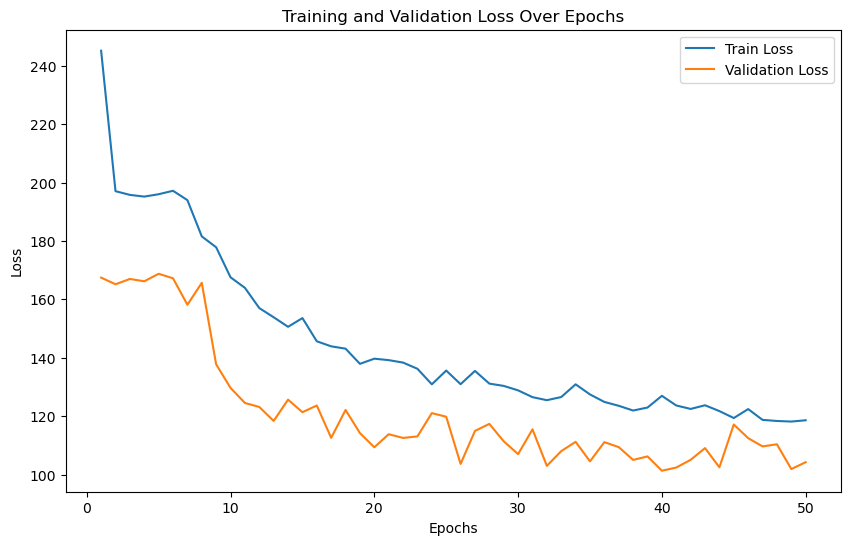

In [ ]:
# Cell 7: Visualize training progress
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()


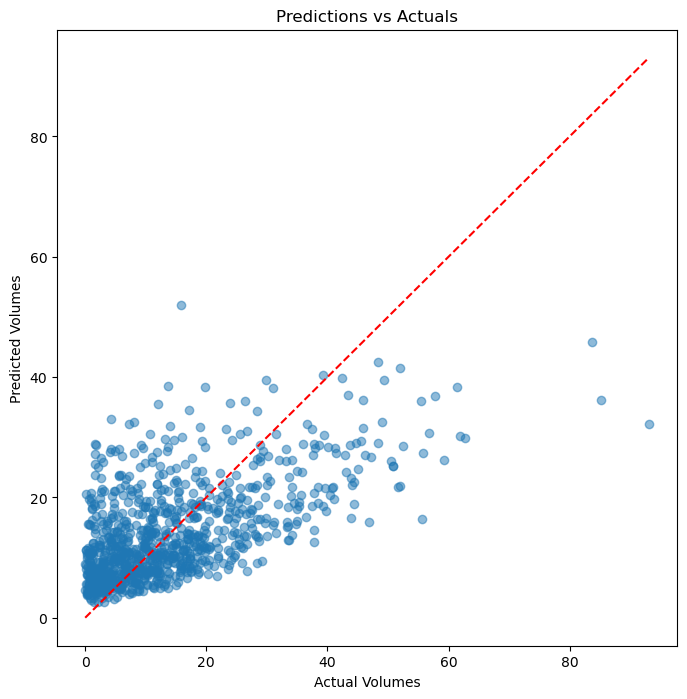

In [ ]:
# Cell 8: Evaluate the model on the test set
model.eval()
predictions = []
actuals = []
with torch.no_grad():
    for data, labels in test_loader:
        data, labels = data.to(device), labels.to(device)
        preds = model(data)
        predictions.extend(preds.cpu().numpy())
        actuals.extend(labels.cpu().numpy())

# Visualize predictions vs actual volumes
plt.figure(figsize=(8, 8))
plt.scatter(actuals, predictions, alpha=0.5)
plt.plot([min(actuals), max(actuals)], [min(actuals), max(actuals)], color='red', linestyle='--')
plt.xlabel('Actual Volumes')
plt.ylabel('Predicted Volumes')
plt.title('Predictions vs Actuals')
plt.show()
